# Quering SQLite from Python

Python 2.5 and up come with the sqlite module, which means we don't need to install any separate libraries to get started. 

Specifically, we'll work with the sqlite3 Python module, which was developed to work with SQLite version 3.

In [63]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt

In [16]:
url = 'https://dsserver-prod-resources-1.s3.amazonaws.com/462/jobs.db'
r = requests.get(url)

with open('/content/jobs.db', 'wb') as f:
    f.write(r.content)

Once we import the module, we connect to the database we want to query using the `connect()` function. 

This function requires a single parameter, which is the database we want to connect to. Because the database we're working with exists as a file on disk, we need to pass in the file name.

The `connect()` function returns a Connection instance, which maintains the connection to the database we want to work with. When we're connected to a database, SQLite locks the database file and prevents any other processes from connecting to the database simultaneously.

In [21]:
conn = sqlite3.connect('/content/jobs.db')

Before we can execute a query, **we need to express our SQL query as a string**. 

While we use the `Connection class` to represent the database we're working with, we use the `Cursor class` to:

* Run a query against the database
* Parse the results from the database
* Convert the results to native Python objects
* Store the results within the Cursor instance as a local variable

After running a query and converting the results to a list of tuples, the Cursor instance stores the list as a local variable.

In [22]:
# Create a Cursor instance
cursor = conn.cursor()
# SQL Query as a string
query = "select * from recent_grads;"
# Execute the query, convert the results to tuples, and store as a local variable
cursor.execute(query)
# Fetch the full results set as a list of tuples
results = cursor.fetchall()
# Display the first three results
print(results[0:3])

[(0, 1, 2419, 'PETROLEUM ENGINEERING', 'Engineering', 2339, 36, 2057, 282, 0.120564344, 1976, 1849, 270, 1207, 37, 0.018380527, 110000, 95000, 125000, 1534, 364, 193), (1, 2, 2416, 'MINING AND MINERAL ENGINEERING', 'Engineering', 756, 7, 679, 77, 0.10185185199999999, 640, 556, 170, 388, 85, 0.117241379, 75000, 55000, 90000, 350, 257, 50), (2, 3, 2415, 'METALLURGICAL ENGINEERING', 'Engineering', 856, 3, 725, 131, 0.153037383, 648, 558, 133, 340, 16, 0.024096386, 73000, 50000, 105000, 456, 176, 0)]


So far, we've run queries by creating a `Cursor instance`, and then calling the execute method on the instance. 

The SQLite library actually allows us to skip creating a Cursor altogether by using the execute method within the Connection object itself. SQLite will create a Cursor instance for us under the hood and run our query against the database, allowing us to skip a step

In [26]:
conn = sqlite3.connect("jobs.db")
query = "select * from recent_grads;"
conn.execute(query).fetchone()

(0,
 1,
 2419,
 'PETROLEUM ENGINEERING',
 'Engineering',
 2339,
 36,
 2057,
 282,
 0.120564344,
 1976,
 1849,
 270,
 1207,
 37,
 0.018380527,
 110000,
 95000,
 125000,
 1534,
 364,
 193)

To make it easier to work with large results sets, the Cursor class allows us to control the number of results we want to retrieve at any given time.

* To return a single result (as a tuple), we use the Cursor method `fetchone()`. 
* To return n results, we use the Cursor method `fetchmany()`.

Because SQLite restricts access to the database file when we're connected to a database, we need to close the connection when we're done working with it. 

Closing the connection allows other processes to access the database, which is important when you're in a production environment and working with other team members.

To close a connection to a database, use the Connection instance method `close()`.

# Analyzing CIA Factbook Data using SQL

In [38]:
# Download database file
url = 'https://dsserver-prod-resources-1.s3.amazonaws.com/257/factbook.db'
r = requests.get(url)
# Save the file with name
open('/content/factbook.db', 'wb').write(r.content)

In [39]:
# Connect to the database
conn = sqlite3.connect('/content/factbook.db')
q1 = "SELECT * FROM sqlite_master WHERE type='table';"
conn.execute(q1).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)')]

In [41]:
pd.read_sql_query(q1,conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [43]:
q2 = "SELECT * FROM facts"
pd.read_sql_query(q2,conn).head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46


Write a single query that returns the:
* Minimum population
* Maximum population
* Minimum population growth
* Maximum population growth

In [44]:
q3 = '''SELECT MIN(population), 
               MAX(population),
               MIN(population_growth),
               MAX(population_growth) 
        FROM facts'''

pd.read_sql_query(q3,conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


1.  Write a query that returns the countrie(s) with the minimum population.
2.  Write a query that returns the countrie(s) with the maximum population.

In [47]:
q4 = ''' SELECT *
          FROM facts
          WHERE population = (SELECT MIN(population) 
                              FROM facts)
    '''
pd.read_sql_query(q4,conn)          

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [48]:
q5 = ''' SELECT * 
          FROM FACTS 
        WHERE population==(SELECT MAX(population) 
                              FROM facts);
      '''
pd.read_sql_query(q5,conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


In [49]:
q6 = '''SELECT MIN(population), 
               MAX(population),
               MIN(population_growth),
               MAX(population_growth) 
        FROM facts
        WHERE name != 'World';
        '''

pd.read_sql_query(q6,conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,1367485388,0.0,4.02


There's a country whose population closes in on 1.4 billion! Let's see what country it is:

In [52]:
q7 = ''' SELECT * 
            FROM facts
            WHERE name <> 'World'
            ORDER BY population DESC
            LIMIT 1;
      '''
pd.read_sql_query(q7,conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44



Let's explore density. Density depends on the population and the country's area. Let's look at the average values for these two columns.

We should take care of discarding the row for the whole planet.


In [51]:
q8 = '''SELECT AVG(population) AS avg_population,
              AVG(area) as avg_area
        FROM facts
        WHERE name <> 'World';
    '''

pd.read_sql_query(q8,conn)

,avg_population,avg_area
0,3.224267e+07,555093.546185


We see that the average population is around 32 million and the average area is 555 thousand square kilometers.

Next, we'll build on the query to find countries that are densely populated. We'll identify countries that have:

* Above average values for population.
* Below average values for area.

In [59]:
q9 = ''' SELECT * 
          FROM facts
          WHERE (
            population > (SELECT AVG(population) 
                                  FROM facts
                                  WHERE name <> 'World')
           AND 
           area < (SELECT AVG(area)
                       FROM facts
                      WHERE name <> 'World')
           );
      '''
pd.read_sql_query(q9,conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,14,bg,Bangladesh,148460,130170,18290,168957745,1.60,21.14,5.61,0.46
1,65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
2,80,iz,Iraq,438317,437367,950,37056169,2.93,31.45,3.77,1.62
3,83,it,Italy,301340,294140,7200,61855120,0.27,8.74,10.19,4.10
4,85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.00
5,91,ks,"Korea, South",99720,96920,2800,49115196,0.14,8.19,6.75,0.00
6,120,mo,Morocco,446550,446300,250,33322699,1.00,18.20,4.81,3.36
7,138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
8,139,pl,Poland,312685,304255,8430,38562189,0.09,9.74,10.19,0.46
9,163,sp,Spain,505370,498980,6390,48146134,0.89,9.64,9.04,8.31


In [62]:
# Which countries have the highest population density?
q10 = '''SELECT name AS country, 
                CAST(population AS float)/CAST(area AS float) AS density 
                FROM facts
                ORDER BY density DESC
                LIMIT 10
        '''
pd.read_sql_query(q10, conn)

,country,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


[]

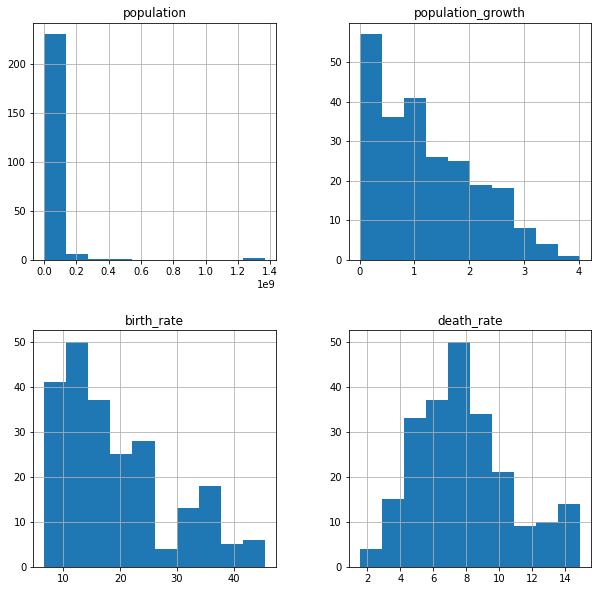

In [71]:
q11=''' SELECT population,
               population_growth,
               birth_rate,
               death_rate 
          FROM facts
          WHERE (
            population != (SELECT MAX(population) 
                            FROM facts)
          AND 
            population != (SELECT MIN(population) 
                              FROM facts)
                );
    '''

pd.read_sql_query(q11,conn).hist(figsize=(10,10))
plt.plot()

# References
* https://www.dataquest.io/course/sql-joins-relations-de
